In [1]:
import sys
import os

sys.path.append(os.path.abspath("../Classifiers"))

from RF import * 

In [2]:
import warnings
warnings.filterwarnings( 'ignore' )
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  f1_score, precision_score, recall_score


### Paths to top30 from GTD data

In [3]:
trains = ['train100', 'train200', 'train300', 'train478']
tests = ['test100', 'test200', 'test300', 'test478', ]
traindir = '../../../../data/top30groups/LongLatCombined/train1'
testdir = '../../../../data/top30groups/LongLatCombined/test1'

trainpaths = []
testpaths = []
for i, partition in enumerate(trains):
    trainpaths.append(f'{traindir}/{partition}.csv')
    testpaths.append(f'{testdir}/{tests[i]}.csv')

### Training models and computing accuracy

In [4]:
models = []
accuracies = []
predictions = []
truths = []
n = [100, 200, 300, 478]
for i, path in enumerate(trainpaths):
    print(f'Computing for partition {i+1}, balanced classes with {n[i]} entries for each class')

    # run classifier on data
    rfc, accuracy, y_pred_rfc, labels = main(trainpaths[i], testpaths[i])

    #  saving models, accuracies, predictions, and truths in case we need it for statistics later
    models.append(rfc)
    accuracies.append(accuracy)
    predictions.append(y_pred_rfc)
    truths.append(labels)

    print("---------------------------------------------------")

Computing for partition 1, balanced classes with 100 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Training best RF classifier...
Making predictions...
Accuracy: 90.33%
---------------------------------------------------
Computing for partition 2, balanced classes with 200 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best RF classifier...
Making predictions...
Accuracy: 91.89%
---------------------------------------------------
Computing for partition 3, balanced classes with 300 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best RF classifier...
Making predictions...
Accuracy: 91.41%
---------------------------------------------------
Computing for partition 4, balanced classes with 478 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best RF classifier...
Making predictions...
Accuracy: 93.03%
------------------------------------------------

In [5]:
with open("Results/rf_top30_LongLatCombined.txt", "w") as f:
    for i in range(len(trainpaths)):
        f.write(f"Partition {i+1} - {n[i]} samples per class, with longitude and latitude data\n")
        f.write(f"Accuracy: {accuracies[i]*100:.2f}%\n")
        f.write(f"Precision Score: {precision_score(truths[i], predictions[i], average='weighted')}\n")
        f.write(f"Precision Score: {recall_score(truths[i], predictions[i], average='weighted')}\n")
        f.write(f"Precision Score: {f1_score(truths[i], predictions[i], average='weighted')}\n")
        f.write("---------------------------------------------------\n")

In [6]:
if not os.path.isdir("Results"):
    os.mkdir("Results")
if not os.path.isdir("Results/LongLatCombined"):
    os.mkdir("Results/LongLatCombined")

In [7]:
def plot_confusion_matrix(y_true, y_pred, labels, partition_id):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_normalized,
                annot=True,
                fmt=".2f",
                xticklabels=labels,
                yticklabels=labels,
                cmap="viridis",
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})

    plt.title(f"Normalized Confusion Matrix (Partition {partition_id})", fontsize=18)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the figure
    save_path = f"Results/LongLatCombined/confusion_matrix_partition_{partition_id}.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"Saved confusion matrix for partition {partition_id} to {save_path}")


In [8]:
for i in range(len(truths)):
    y_true = truths[i]
    y_pred = predictions[i]

    # Get all unique class labels from the truths
    class_labels = np.unique(np.concatenate(truths))

    plot_confusion_matrix(y_true, y_pred, labels=class_labels, partition_id=i + 1)

# Combined
all_true = np.concatenate(truths)
all_pred = np.concatenate(predictions)
all_labels = np.unique(all_true)

plot_confusion_matrix(all_true, all_pred, labels=all_labels, partition_id="All")


Saved confusion matrix for partition 1 to Results/LongLatCombined/confusion_matrix_partition_1.png
Saved confusion matrix for partition 2 to Results/LongLatCombined/confusion_matrix_partition_2.png
Saved confusion matrix for partition 3 to Results/LongLatCombined/confusion_matrix_partition_3.png
Saved confusion matrix for partition 4 to Results/LongLatCombined/confusion_matrix_partition_4.png
Saved confusion matrix for partition All to Results/LongLatCombined/confusion_matrix_partition_All.png


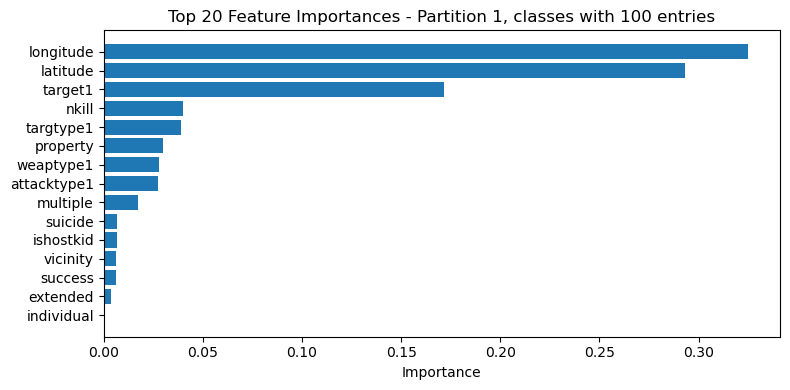

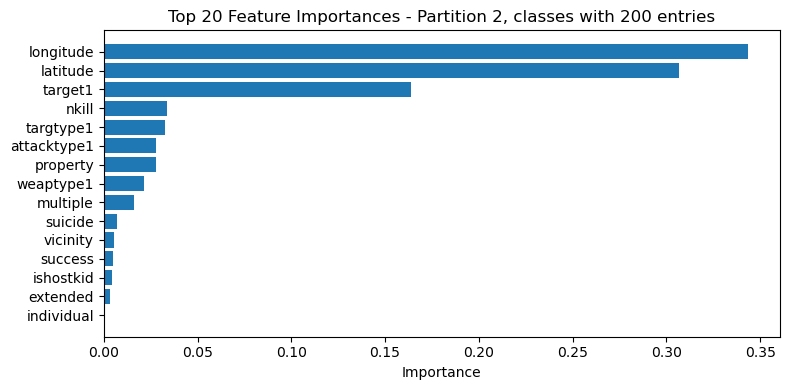

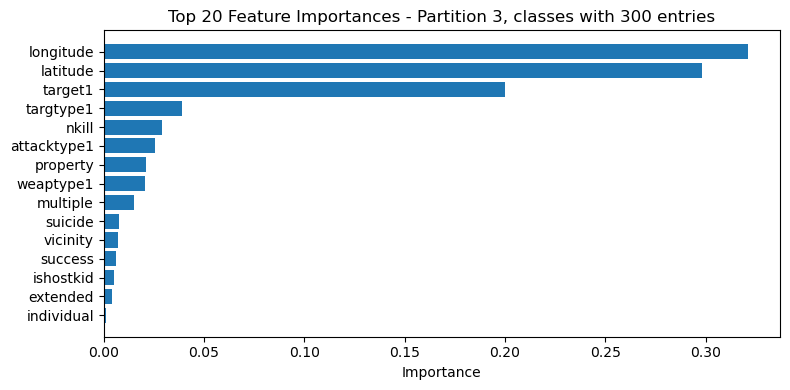

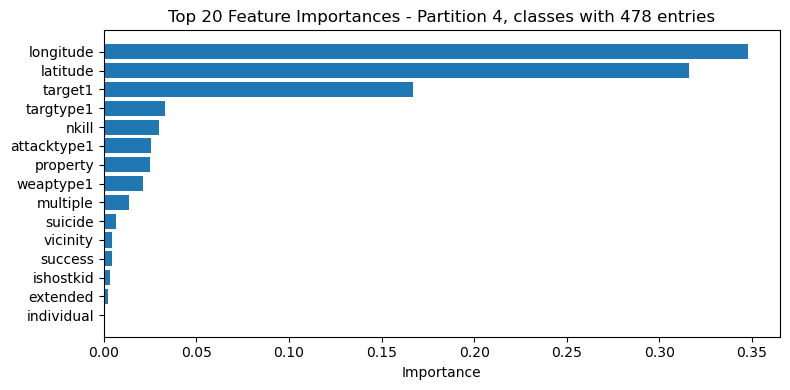

In [9]:
top_k = 20

for i, rfc in enumerate(models):
    importances = rfc.feature_importances_

    feature_names = rfc.feature_names_in_

    indices = np.argsort(importances)[::-1][:top_k]
    top_features = [feature_names[j] for j in indices]
    top_importances = importances[indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_features[::-1], top_importances[::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_k} Feature Importances - Partition {i+1}, classes with {n[i]} entries")
    plt.tight_layout()
    plt.show()